In [1]:
from torch.cuda.random import seed
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from torchvision.io import read_image
import random
from PIL import Image , ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as Tran
from torchvision .models .detection. faster_rcnn import FastRCNNPredictor
torch.manual_seed(42)

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [2]:
#Reading the csv file
bd = pd.read_csv('/content/train_solution_bounding_boxes (1).csv')
bd.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [3]:
#Getting unique images from the training images and csv file.
img_pth = '/content/training_images/'
img_unq = bd.image.unique()
print("The number of unique images is:",len(img_unq))

The number of unique images is: 355


In [4]:
#Creating DLCarData using the training_images
class DLCarData(torch.utils.data.Dataset):
    def __init__(self, bd, img_unq, indcs):
        self.bd = bd
        self.img_unq = img_unq
        self.indices = indcs

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        img_name = self.img_unq[self.indices[index]]
        bbx = self.bd[self.bd.image == img_name].values[: , 1:].astype("float")
        img = Image.open(img_pth + img_name).convert('RGB')
        labels = torch.ones((bbx.shape[0]) , dtype = torch.int64)
        targt = {}
        targt["boxes"] = torch.tensor(bbx)
        targt["label"] = labels

        return Tran.ToTensor()(img) , targt

In [5]:
#Splitting the DLCarData into Training dataset and Validation Dataset    
tr_indcs , vl_indcs = train_test_split(range(img_unq.shape[0]) , test_size = 0.4)

def collate(data):
    return data

tr_dlr = torch.utils.data.DataLoader(DLCarData(bd , img_unq, tr_indcs), 
                                       batch_size = 4,
                                       shuffle = True,
                                       collate_fn = collate,
                                       pin_memory = True if torch.cuda.is_available() else False)
                                       
vl_dlr = torch.utils.data.DataLoader(DLCarData(bd , img_unq, vl_indcs), 
                                       batch_size = 2,
                                       shuffle = True,
                                       collate_fn = collate,
                                       pin_memory = True if torch.cuda.is_available() else False)

In [6]:
#Downloading pretrainedmodel Resnet 50 for training the custom dataset
CarModel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
ncs = 2
n_fetures = CarModel.roi_heads.box_predictor.cls_score.in_features
CarModel.roi_heads.box_predictor = FastRCNNPredictor(n_fetures , ncs)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 95.3MB/s]


In [7]:
#Activating the GPU and using CUDA
dvce = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(dvce)

cuda:0


In [8]:
#Setting ther optimizer value
optmzr = torch.optim.SGD(CarModel.parameters() , lr=0.001, momentum=0.9, weight_decay=0.0005)

In [9]:
#Training the DLCarData Model
from tqdm import tqdm

ne = 50
CarModel.to(dvce)
for epochs in range(ne):
    epoch_loss = 0
    progress_bar = tqdm(tr_dlr, desc=f'Epoch {epochs + 1}/{ne}')
    for data in progress_bar:
        img = []
        targets = []
        for d in data:
            img.append(d[0].to(dvce))
            targt = {}
            targt["boxes"] = d[1]["boxes"].to(dvce)
            targt["labels"] = d[1]["label"].to(dvce)
            targets.append(targt)
        ls_dict = CarModel(img , targets)
        ls = sum(v for v in ls_dict.values())
        epoch_loss += ls.cpu().detach().numpy()
        optmzr.zero_grad()
        ls.backward()
        optmzr.step()
       
    print(f'Loss = {epoch_loss}')

Epoch 1/50: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Loss = 16.05542157575781


Epoch 2/50: 100%|██████████| 54/54 [00:57<00:00,  1.06s/it]


Loss = 7.5899325445384624


Epoch 3/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 6.580522355405771


Epoch 4/50: 100%|██████████| 54/54 [01:00<00:00,  1.11s/it]


Loss = 6.111083754236201


Epoch 5/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 5.855705713593698


Epoch 6/50: 100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


Loss = 5.376864496472799


Epoch 7/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 5.159232621151145


Epoch 8/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 4.934454034443856


Epoch 9/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 4.695829229399363


Epoch 10/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 4.616364980305749


Epoch 11/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 4.454611410317769


Epoch 12/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 4.190556022617318


Epoch 13/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 3.9969682183633024


Epoch 14/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 3.810591811883427


Epoch 15/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 3.5817774810568115


Epoch 16/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 3.433928655849054


Epoch 17/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 3.2754074943606404


Epoch 18/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 3.1519978645006352


Epoch 19/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 3.13864715785984


Epoch 20/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 2.899896419649823


Epoch 21/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 2.6965839658658486


Epoch 22/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 2.604627065308647


Epoch 23/50: 100%|██████████| 54/54 [01:01<00:00,  1.14s/it]


Loss = 2.5157422885182705


Epoch 24/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 2.4589705702316746


Epoch 25/50: 100%|██████████| 54/54 [01:01<00:00,  1.14s/it]


Loss = 2.353758619345634


Epoch 26/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 2.1958174027092365


Epoch 27/50: 100%|██████████| 54/54 [01:01<00:00,  1.14s/it]


Loss = 2.178295261856362


Epoch 28/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 2.121324955182229


Epoch 29/50: 100%|██████████| 54/54 [01:01<00:00,  1.14s/it]


Loss = 2.0479621085716007


Epoch 30/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.932661463164958


Epoch 31/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.8804930617109614


Epoch 32/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.7461125725381148


Epoch 33/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.7224892895657937


Epoch 34/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.6629377330412038


Epoch 35/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.6442703243037782


Epoch 36/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.5944883243144445


Epoch 37/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.6449943294608864


Epoch 38/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.599577536206074


Epoch 39/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.4842489539966324


Epoch 40/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.4127544635623475


Epoch 41/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.432812849955983


Epoch 42/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.3473701422070168


Epoch 43/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.3368735284080242


Epoch 44/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.3324765032673


Epoch 45/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 1.3152051480713516


Epoch 46/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.277193988747663


Epoch 47/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.2636294130539723


Epoch 48/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.2039424794371996


Epoch 49/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


Loss = 1.2599766960509118


Epoch 50/50: 100%|██████████| 54/54 [01:00<00:00,  1.13s/it]

Loss = 1.171501501206522


In [14]:
#Saving the trained model in the Working Directory
torch.save(CarModel.state_dict(), 'CarModel.pt')

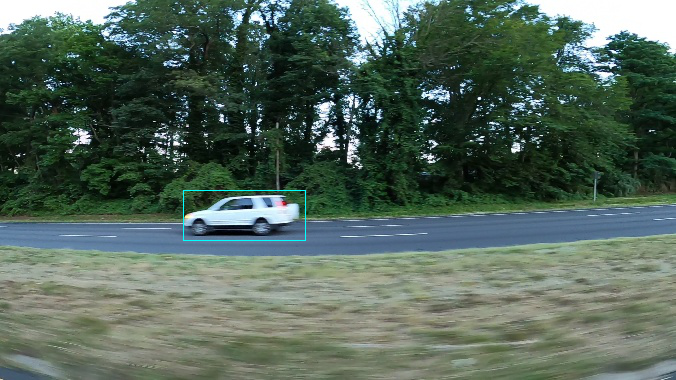

In [16]:
#Displaying the Validation images
CarModel.eval()

dt = iter(vl_dlr).__next__()
img = dt[0][0]
bbxs = dt[0][1]["boxes"]
lbls = dt[0][1]["label"]
rslt = CarModel([img.to(dvce)])
rslt_bbx = rslt[0]["boxes"]
rslt_scrs = rslt[0]["scores"]
kep = torchvision.ops.nms(rslt_bbx , rslt_scrs, 0.45)
rslt_bbx.shape , kep.shape
imn =(img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
rsmple = Image.fromarray(imn)
draw = ImageDraw.Draw(rsmple)
for box in bbxs:
    draw.rectangle(list(box) , fill = None , outline = 'cyan')
rsmple

In [123]:
CarModel.eval()

tcorrect = 0
tsamples = 0

with torch.no_grad():
    for data in vl_dlr:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(dvce))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(dvce)
            targ["labels"] = d[1]["label"].to(dvce)
            targets.append(targ)
        
        opt = CarModel(imgs)
        for i in range(len(opt)):
            pred_boxes = opt[i]['boxes']
            pred_labels = opt[i]['labels']
            
            # perform non-maximum suppression to get the final predicted boxes
            keep = torchvision.ops.nms(pred_boxes, pred_labels, iou_threshold=0.5)
            pred = pred_boxes[keep]
            pred = pred_labels[keep]

            # count the number of correct predictions
            for j in range(len(pred_boxes)):
                tboxes = targets[i]['boxes']
                tlabels = targets[i]['labels']
                tboxes = tboxes[tlabels == 1]
                iou = torchvision.ops.box_iou(pred_boxes[j].unsqueeze(0), tboxes)
                if iou.max() > 0.815:
                    tcorrect += 1
        
        tsamples += len(data)

valid_acc = tcorrect / tsamples
print("The Validation accuracy is = {:.2f}%".format(valid_acc * 100))

The Validation accuracy is = 98.59%


In [24]:
import torch
torch.cuda.empty_cache()

In [112]:
import os
import random
import torch
import torchvision
from PIL import Image, ImageDraw
from tqdm import tqdm
from torchvision import transforms as Tr


# Loading the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
model.load_state_dict(torch.load('CarModel.pt'))
model.eval()

# Defining the path to the images
testingpath = '/content/testing_images'
names = os.listdir(testingpath)


all_boxes = []


iou_threshold = 0.2
print("Predicting Boxes of the Test Data")

for name in tqdm(names):
    
    image = Image.open(os.path.join(testingpath, name)).convert('RGB')
    
    #Predict the car in the images
    with torch.no_grad():
        pred = model([Tr.ToTensor()(image)])
    
    #Predict boxes and labels
    boxes = pred[0]['boxes'].detach().numpy()
    scores = pred[0]['scores'].detach().numpy()
    labels = pred[0]['labels'].detach().numpy()
    
    
    kp_indices = torchvision.ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)
    boxes = boxes[kp_indices]
    labels = labels[kp_indices]
    
    # Add boxes and label to list
    all_boxes.append({'image_name': name, 'boxes': boxes, 'labels': labels})


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicting Boxes of the Test Data


100%|██████████| 175/175 [22:03<00:00,  7.56s/it]


In [113]:
#Importing the font for displaying distance
import os
import urllib.request
font_url = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true'
font_path = '/content/fonts/Roboto-Regular.ttf'
os.makedirs(os.path.dirname(font_path), exist_ok=True)
urllib.request.urlretrieve(font_url, font_path)

('/content/fonts/Roboto-Regular.ttf',
 <http.client.HTTPMessage at 0x7f50ae562490>)

Displaying The Images with Distance 
vid_5_26900.jpg


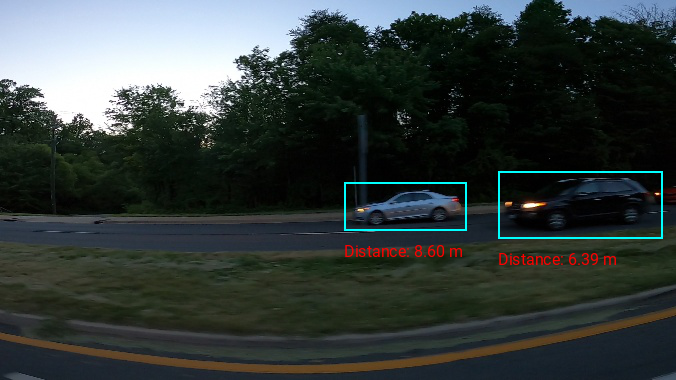

vid_5_29420.jpg


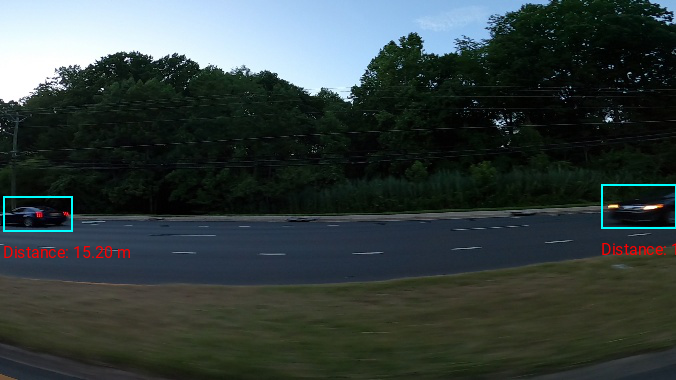

In [122]:
print("Displaying The Images with Distance ")
for i in range(2):
    #Random image from list
    img_info = random.choice(all_boxes)

    imge = Image.open(os.path.join(testingpath, img_info['image_name'])).convert('RGB')

    # Predicted boxes drawing
    dr = ImageDraw.Draw(imge)
    for l in range(len(img_info['boxes'])):
        box = img_info['boxes'][l]
        labels = img_info.get('labels', [])
        if isinstance(labels, int):
            labels = [labels]
        if len(labels) > l:
            label = labels[l]
        else:
            label = ''
        dr.rectangle([(box[0], box[1]), (box[2], box[3])], outline='cyan', width=2)
        #dr.text((box[0], box[1]), str(label), fill='red')

        # Distance of car using camera
        crwidth = 210  #width of car in cm
        folength = 5   #camera's focal length in cm
        crpixelwidth = box[2] - box[0]
        dist = (crwidth * folength) / crpixelwidth

        # Font existence check
        if os.path.isfile('/content/fonts/Roboto-Regular.ttf'):
            fnt = ImageFont.truetype('/content/fonts/Roboto-Regular.ttf', 16)
            dr.text((box[0], box[3] + 10), f"Distance: {dist:.2f} m", fill='red', font=fnt)
        else:
            dr.text((box[0], box[3] + 10), f"Distance: {dist:.2f} m", fill='red')

    # Display the image
    print(img_info['image_name'])
    imge.show()
